# Métodos de Diferencias Temporales (TD)

En este notebook vamos a ver métodos de diferencias temporales en particular, vamos a ver un método de control on-policy (Sarsa) y un método off-policy (Q-Learning) para estimar la funcion de valor (y la política) ótima para un problema. 


El notebook se basa en el capítulo 6 del libro de Sutton y Barto.


****

## Ambiente

Vamos a utilizar un problema clásico de Reinforcement Learning, y para ello vamos a usar otro ambiente de OpenAi gym: MountainCar: https://gym.openai.com/envs/MountainCar-v0/ o https://gymnasium.farama.org/environments/classic_control/mountain_car/.

La descripcion del mismo es la siguiente:

Un auto esta posicionado en un carril de una dimension entre dos montañas. El objetivo es llegar a la cima de la montaña derecha pero, el motor del auto no es lo suficientemente fuerte para hacerlo en una sola pasada (no puede simplemente acelerar y llegar). Entonces, la única forma de tener éxito es ir de atrás hacia delante repetidas veces para acumular suficiente energía para subir.

![Image](https://i.ytimg.com/vi/slIJHOuTCmc/hqdefault.jpg)

Este ambiente tiene representación gráfica visual en gym, para ello vamos a hacer uso de unas funciones auxliares para poder ver resultados en video en colab.


****

## A entregar:

- Implementación de algoritmo Q-Learning
- Implementacion de algoritmo Sarsa
- Comparacion entre ambos para el ambiente dado, cuanto tarda cada uno en llegar al objetivo (en promedio). 





### Funciones auxiliares para visualizar el ambiente

In [1]:
# Dependencias necesarias.
!pip install --upgrade gymnasium > /dev/null 2>&1
!pip install --upgrade pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
# Para ejecutar en CECOFI
#!pip install moviepy
#!pip install gymnasium[classic-control]

In [2]:
# Imports y funciones para ver el ambiente.
from tqdm.notebook import tqdm_notebook
import io
#import gym
import gymnasium as gym
import glob
import base64
#from gym.wrappers import Monitor
from gymnasium.wrappers.record_video import RecordVideo
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay


display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
  """
  Utility function to enable video recording of gym environment and displaying it
  To enable video, just do "env = wrap_env(env)""
  """
  mp4list = glob.glob('./videos/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  """
  Wrapper del ambiente donde definimos un Monitor que guarda la visualizacion como un archivo de video.
  """
  
  #env = Monitor(env, './video', force=True)
  env = RecordVideo(env,video_folder='./videos')
  return env

### Creación del ambiente y visualizacion de un agente aleatorio.



In [3]:
# Necesitamos "envolver" el ambiente para hacer uso de las funciones definidas anteriormente.
env = wrap_env(gym.make("MountainCar-v0",render_mode="rgb_array"))

# El resto del código es igual a lo que venimos acostumbrados.
observation,_ = env.reset()

while True:
    env.render()  # Queremos poder ver el ambiente. 

    action = env.action_space.sample() 
    observation, reward, done, truncated, info = env.step(action) 
        
    if done or truncated:
      break

# Cerramos la conexion con el Monitor de ambiente y mostramos el video.
env.close()
show_video()

del env

Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4


### Interacción con el ambiente

El ambiente cuenta con 3 acciones: Acelerar a la izquierda, frenar y acelerar a la derecha. Las recompensas son -1 por cada accion tomada con excepcion de llegar a la cima de la montaña. Un episodio se termina al alcanzar la cima o al luego de 200 interacciones.

Lo que podemos observar al interactuar con el es un valor real para su Velocidad (negativa al ir para la izquierda, positiva a la derecha) y un valor real para su Posicion en la línea.

Ambos valores son continuos, esto nos representa un problema, ya que queremos modelar una función de valor y una política para todos los estados posibles.

Para atacar este problema vamos a **DISCRETIZAR** el ambiente, esto es: convertir la posicion y velocidad del auto en valores discretos dentro de un rango definido.

Para ello vamos a definir algunas constantes y una función que nos permite obtener una representacion discreta de las observaciones del ambiente.


In [4]:
env = gym.make("MountainCar-v0")
# Obtiene los límites inferiores del espacio de observaciones
env_low = env.observation_space.low
print(env_low)
# Obtiene los límites superiores del espacio de observaciones
env_high = env.observation_space.high
print(env_high)

[-1.2  -0.07]
[0.6  0.07]


In [5]:
import numpy as np

# We will use 40 different values for Position and 40 for velocity (40x40 combinations)
NUMBER_STATES = 40

def discretization(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    
    # Calcula el intervalo de discretización para cada dimensión del espacio de observaciones (posición y velocidad)
    env_den = (env_high - env_low) / NUMBER_STATES
    pos_den = env_den[0]
    vel_den = env_den[1]
    
    pos_low = env_low[0]
    vel_low = env_low[1]

    # Escala la posición y la velocidad del estado continuo y los convierte en índices enteros discretos
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    
    # Retorna la posición y la velocidad discretizadas como una tupla
    return pos_scaled, vel_scaled

Una vez tenemos el ambiente discretizado, podemos crear una tabla que contenga el valor esperado para cada estado posible (donde en este caso, cada estado es una terna de: posicion, velocidad y accion a tomar). 

Esta tabla es normalmente conocida como "Q table" por su uso en Q learning (aunque tambien se usa, pero de manera distinta en Sarsa).

### Q-Learning

Vamos a comenzar implementando Q-learning para el problema actual, la implementacion corre por parte de los estudiantes.

Recordamos aquí el algoritmo:

![Image](https://leimao.github.io/images/blog/2019-03-14-RL-On-Policy-VS-Off-Policy/q-learning.png)

In [7]:
# Implementación de Q-Learning para entrenar un agente en un entorno proporcionado.

def q_learning(env, number_episodes=100, alpha=0.1, gamma=0.9, epsilon_start=0.9, epsilon_min=0.1, epsilon_decay=0.9):
    """
    La función q_learning entrena un agente en un entorno utilizando Q-Learning con
    parámetros personalizables. Devuelve la tabla Q, las recompensas por episodio,
    los pasos por episodio y las victorias (llegar a la meta) por episodio.
    """

    # Inicializar la tabla Q y epsilon
    Q_table = np.zeros((NUMBER_STATES, NUMBER_STATES, env.action_space.n))
    epsilon = epsilon_start

    # Rastreadores de estadísticas
    episode_rewards = []
    episode_steps = []
    wins = []

    for ep_idx in tqdm_notebook(range(number_episodes)):
        # Restablecer el entorno y obtener posición y velocidad iniciales
        observation, info = env.reset()
        position, velocity = discretization(env, observation)
        done = False
        truncated = False
        rewards = 0
        steps = 0

        while not (done or truncated):
            # Política epsilon-greedy
            action = np.argmax(Q_table[position][velocity])
            if np.random.uniform() < epsilon:
                action = np.random.choice(env.action_space.n)

            # Realizar la acción y observar el resultado
            new_observation, reward, done, truncated, _ = env.step(action)
            new_position, new_velocity = discretization(env, new_observation)

            # Regla de actualización de Q-Learning
            Q_table[position][velocity][action] += alpha * (reward + gamma * np.max(Q_table[new_position][new_velocity]) - Q_table[position][velocity][action])

            # Avanzar al siguiente estado
            position, velocity = new_position, new_velocity
            rewards += reward
            steps += 1

        episode_rewards.append(rewards)
        episode_steps.append(steps)

        # Contar el número de "victorias" (llegar a la meta) en el entorno del mountain car
        if done:
            wins.append(1)
        else:
            wins.append(0)

        # Actualizar epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    return Q_table, episode_rewards, episode_steps, wins


In [8]:
env = gym.make("MountainCar-v0")
NUMBER_EPISODES = 4000
q_table, rewards, steps, wins = q_learning(env, number_episodes=NUMBER_EPISODES, alpha=0.3, epsilon_decay=0.5)

  0%|          | 0/4000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/monitoring/video_recorder.py:182: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


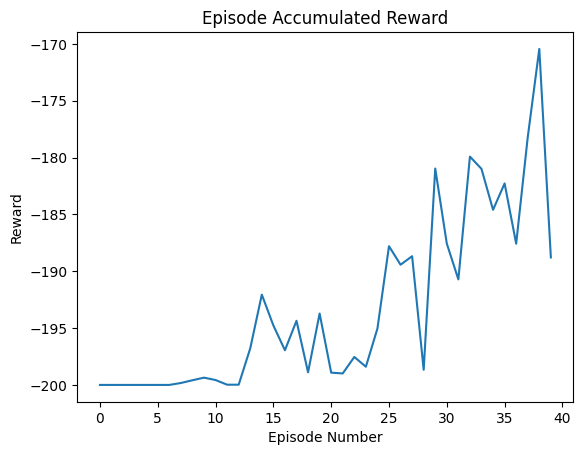

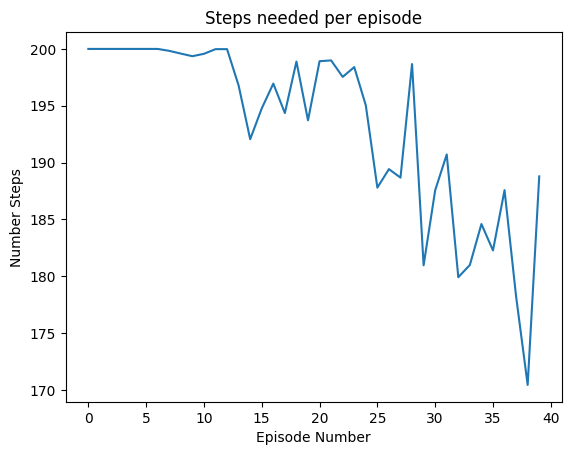

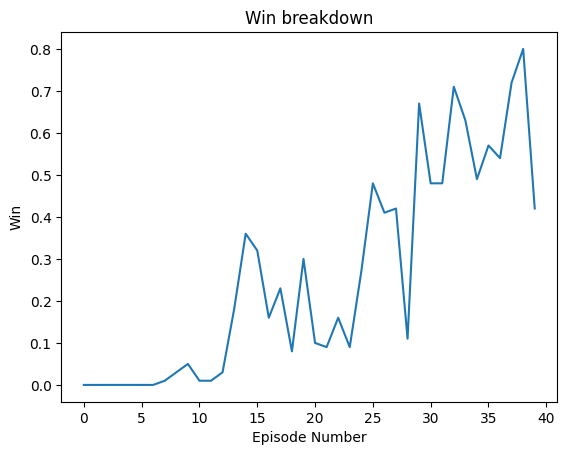

In [9]:
import matplotlib.pyplot as plt

# Promediar los resultados cada N episodios para una mejor visualización
average_range = 100
episode_ticks = int(NUMBER_EPISODES / average_range)

# Calcular la recompensa promedio, los pasos promedio y las victorias promedio cada 'average_range' episodios
avg_rewards = np.array(rewards).reshape((episode_ticks, average_range))
avg_rewards = np.mean(avg_rewards, axis=1)

avg_steps = np.array(steps).reshape((episode_ticks, average_range))
avg_steps = np.mean(avg_steps, axis=1)

avg_wins = np.array(wins).reshape((episode_ticks, average_range))
avg_wins = np.mean(avg_wins, axis=1)

# Plot

# Gráfico de Recompensa Acumulada por Episodio
plt.plot(range(episode_ticks), avg_rewards)
plt.title("Episode Accumulated Reward")
plt.xlabel("Episode Number")
plt.ylabel("Reward")
plt.show()

# Gráfico de Pasos necesarios por episodio
plt.plot(range(episode_ticks), avg_steps)
plt.title("Steps needed per episode")
plt.xlabel("Episode Number")
plt.ylabel("Number Steps")
plt.show()

# Gráfico de Desglose de victorias
plt.plot(range(episode_ticks), avg_wins)
plt.title("Win breakdown")
plt.xlabel("Episode Number")
plt.ylabel("Win")
plt.show()

## Visualizacion del agente

Vamos a ejecutar una política completamente greedy para observar lo aprendido por el algoritmo, usando la q_table retornada por el mismo para decidir la mejor accion.


In [10]:
# Crear el entorno "MountainCar-v0" y wrapearlo para grabar un video
env = wrap_env(gym.make("MountainCar-v0",render_mode="rgb_array"))

# Restablecer el entorno y obtener la posición y velocidad iniciales
observation,_ = env.reset()
position, velocity = discretization(env, observation)

# Bucle principal para visualizar el agente ejecutando la política aprendida
while True:
    # Renderizar el entorno
    env.render()


    # Seleccionar la acción utilizando la política aprendida (tabla Q)
    action = np.argmax(q_table[position][velocity])
    # Realizar la acción y observar el resultado
    observation, reward, done, truncated, info = env.step(action) 
    # Actualizar la posición y velocidad discretizadas
    position, velocity = discretization(env, observation)

    # Actualizar la posición y velocidad discretizadas
    if done or truncated:
      break

# Cerramos la conexion con el Monitor de ambiente y mostramos el video.
env.close()
show_video()

# Eliminar el entorno
del env

Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4


### Implementación de Sarsa


![Image](https://miro.medium.com/max/2612/1*Wim9wr-jYJtZyZ_4ZJRHNg.jpeg)

In [11]:
def sarsa(env, number_episodes=100, alpha=0.1, gamma=0.9, epsilon_start=0.9, epsilon_min=0.1, epsilon_decay=0.9):

    # Inicializar la tabla Q y epsilon
    Q_table = np.zeros((NUMBER_STATES, NUMBER_STATES, env.action_space.n))
    epsilon = epsilon_start

    # Rastreadores de estadísticas
    episode_rewards = []
    episode_steps = []
    wins = []

    for ep_idx in tqdm_notebook(range(number_episodes)):
        # Restablecer el entorno y obtener posición y velocidad iniciales
        observation, info = env.reset()
        position, velocity = discretization(env, observation)
        done = False
        truncated = False
        rewards = 0
        steps = 0

        # Política epsilon-greedy
        action = np.argmax(Q_table[position][velocity])
        if np.random.uniform() < epsilon:
            action = np.random.choice(env.action_space.n)

        while not (done or truncated):
            # Realizar la acción y observar el resultado
            new_observation, reward, done, truncated, _ = env.step(action)
            new_position, new_velocity = discretization(env, new_observation)

            # Política epsilon-greedy
            new_action = np.argmax(Q_table[new_position][new_velocity])
            if np.random.uniform() < epsilon:
                new_action = np.random.choice(env.action_space.n)

            # Regla de actualización de Sarsa
            Q_table[position][velocity][action] += alpha * (reward + gamma * Q_table[new_position][new_velocity][new_action] - Q_table[position][velocity][action])

            # Avanzar al siguiente estado
            position, velocity = new_position, new_velocity
            action = new_action
            rewards += reward
            steps += 1

        episode_rewards.append(rewards)
        episode_steps.append(steps)

        # Contar el número de "victorias" (llegar a la meta) en el entorno del mountain car
        if done:
            wins.append(1)
        else:
            wins.append(0)

        # Actualizar epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    return Q_table, episode_rewards, episode_steps, wins

In [12]:
env = gym.make("MountainCar-v0")
NUMBER_EPISODES = 4000
q_table, rewards, steps, wins = sarsa(env, number_episodes=NUMBER_EPISODES, alpha=0.3, epsilon_decay=0.5)

  0%|          | 0/4000 [00:00<?, ?it/s]

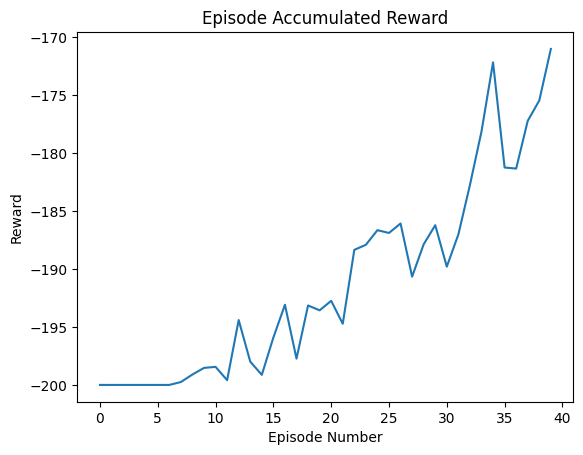

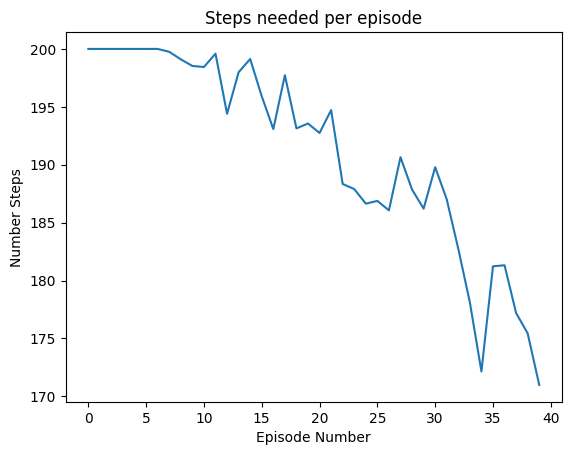

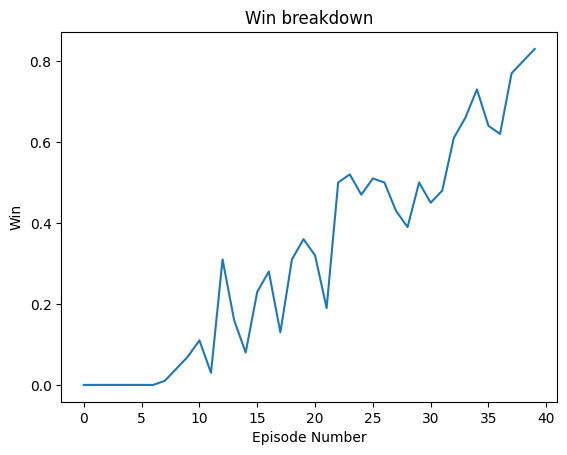

In [13]:
# Promediar los resultados cada N episodios para una mejor visualización
average_range = 100
episode_ticks = int(NUMBER_EPISODES / average_range)

# Calcular la recompensa promedio, los pasos promedio y las victorias promedio cada 'average_range' episodios
avg_rewards = np.array(rewards).reshape((episode_ticks, average_range))
avg_rewards = np.mean(avg_rewards, axis=1)

avg_steps = np.array(steps).reshape((episode_ticks, average_range))
avg_steps = np.mean(avg_steps, axis=1)

avg_wins = np.array(wins).reshape((episode_ticks, average_range))
avg_wins = np.mean(avg_wins, axis=1)

# Gráficas

# Gráfico de Recompensa Acumulada por Episodio
plt.plot(range(episode_ticks), avg_rewards)
plt.title("Episode Accumulated Reward")
plt.xlabel("Episode Number")
plt.ylabel("Reward")
plt.show()

# Gráfico de Pasos necesarios por episodio
plt.plot(range(episode_ticks), avg_steps)
plt.title("Steps needed per episode")
plt.xlabel("Episode Number")
plt.ylabel("Number Steps")
plt.show()

# Gráfico de Desglose de victorias
plt.plot(range(episode_ticks), avg_wins)
plt.title("Win breakdown")
plt.xlabel("Episode Number")
plt.ylabel("Win")
plt.show()


In [14]:
env = wrap_env(gym.make("MountainCar-v0",render_mode="rgb_array"))

observation,_ = env.reset()
position, velocity = discretization(env, observation)

while True:
    env.render()

    action = np.argmax(q_table[position][velocity])
    observation, reward, done, truncated, info = env.step(action) 
    
    position, velocity = discretization(env, observation)

    if done or truncated:
      break

# Cerramos la conexion con el Monitor de ambiente y mostramos el video.
env.close()
show_video()

del env

Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4
